<a href="https://colab.research.google.com/github/pranathadoddy/Potato-DL/blob/main/ResnetPotato.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import datasets

from torchvision import datasets
from torchvision import transforms

from torchvision import models

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from PIL import Image

In [ ]:
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 50

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir ~/.kaggle

In [ ]:
! cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/

In [ ]:
! kaggle datasets download aarishasifkhan/plantvillage-potato-disease-dataset

Dataset URL: https://www.kaggle.com/datasets/aarishasifkhan/plantvillage-potato-disease-dataset
License(s): Apache 2.0
 95% 36.0M/37.8M [00:02<00:00, 21.1MB/s]
100% 37.8M/37.8M [00:02<00:00, 14.0MB/s]


In [ ]:
! unzip plantvillage-potato-disease-dataset.zip

Archive:  plantvillage-potato-disease-dataset.zip
  inflating: PlantVillage/Potato___Early_blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG  
  inflating: PlantVillage/Potato___Early_blight/002a55fb-7a3d-4a3a-aca8-ce2d5ebc6925___RS_Early.B 8170.JPG  
  inflating: PlantVillage/Potato___Early_blight/009c8c31-f22d-4ffd-8f16-189c6f06c577___RS_Early.B 7885.JPG  
  inflating: PlantVillage/Potato___Early_blight/00d8f10f-5038-4e0f-bb58-0b885ddc0cc5___RS_Early.B 8722.JPG  
  inflating: PlantVillage/Potato___Early_blight/0182e991-97f0-4805-a1f7-6e1b4306d518___RS_Early.B 7015.JPG  
  inflating: PlantVillage/Potato___Early_blight/02578b86-b234-4ac0-9bc3-691b5610e2bf___RS_Early.B 7562.JPG  
  inflating: PlantVillage/Potato___Early_blight/0267d4ca-522e-4ca0-b1a2-ce925e5b54a2___RS_Early.B 7020.JPG  
  inflating: PlantVillage/Potato___Early_blight/028f9b73-142f-499a-9c7b-d7c1ed5e5506___RS_Early.B 8546.JPG  
  inflating: PlantVillage/Potato___Early_blight/034959c1-f1e8-4a79-a6d5-3c1d14

In [ ]:
early_blight_folder = "/content/PlantVillage/Potato___Early_blight"
late_blight_folder = "/content/PlantVillage/Potato___Late_blight"
healthy_folder = "/content/PlantVillage/Potato___healthy"

# Function to extract filenames and assign class
def create_df_from_folder(folder, class_value):
    files = os.listdir(folder)
    df = pd.DataFrame({'image_name': files, 'class': class_value})
    return df

# Create DataFrames for each folder
early_blight_df = create_df_from_folder(early_blight_folder, 1)
late_blight_df = create_df_from_folder(late_blight_folder, 2)
healthy_df = create_df_from_folder(healthy_folder, 0)

# Concatenate the DataFrames
df = pd.concat([early_blight_df, late_blight_df, healthy_df], ignore_index=True)

df.set_index('image_name', inplace=True)
df

,class
image_name,
6fc04d72-747b-4a96-912a-db0bd967ece0___RS_Early.B 8002.JPG,1
e3007682-ad4b-4a62-b64d-ebb0c4537077___RS_Early.B 7772.JPG,1
211094c5-4983-49ff-a92e-b992039bd048___RS_Early.B 6927.JPG,1
a4ac4e39-1342-4b1d-806a-98789876a701___RS_Early.B 8953.JPG,1
77b04047-8450-47d1-82f1-48f09f83387c___RS_Early.B 7042.JPG,1
...,...
f4b5ec24-d318-4309-8294-9126450d5d7f___RS_HL 1824.JPG,0
2ccb9ee9-faac-4d32-9af5-29497fa2e028___RS_HL 1837.JPG,0
5d505af8-3f73-4781-980c-a4a696a04550___RS_HL 1934.JPG,0


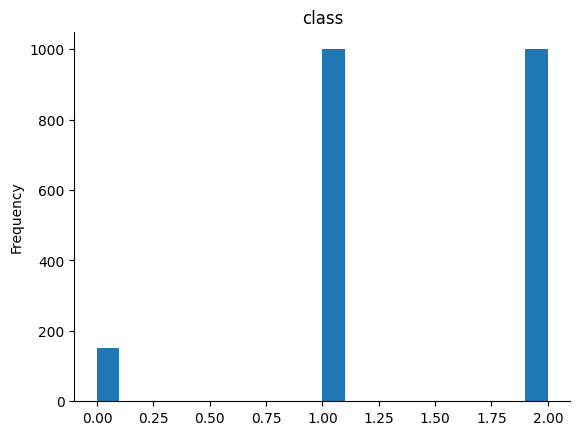

In [ ]:
# @title class

from matplotlib import pyplot as plt
df['class'].plot(kind='hist', bins=20, title='class')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
train, test_df = train_test_split(df, test_size = 0.2, random_state=1, shuffle=True)

validate, test = train_test_split(test_df, test_size=0.5, random_state=1, shuffle=True)
train.groupby('class').size(), validate.groupby('class').size(), test.groupby('class').size()

(class
 0    130
 1    810
 2    781
 dtype: int64,
 class
 0     11
 1     87
 2    117
 dtype: int64,
 class
 0     11
 1    103
 2    102
 dtype: int64)

In [ ]:
train.to_csv('potato_train.csv')
validate.to_csv('potato_valid.csv')
test.to_csv('potato_test.csv')

In [ ]:
class PotatoDataset(Dataset):

    def __init__(self, csv_path, img_dir, transform=None):

        df = pd.read_csv(csv_path, index_col=0)
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df.index.values
        self.y = df['class'].values
        self.transform = transform

    def __getitem__(self, index):
        directory = 'Potato___healthy'
        if self.y[index] == 1:
           directory = 'Potato___Early_blight'
        elif self.y[index] == 2:
          directory = 'Potato___Late_blight'

        img = Image.open(os.path.join(self.img_dir+directory,
                                      self.img_names[index]))
        img = img.convert('RGBA')

        if self.transform is not None:
            img = self.transform(img)


        label = self.y[index]

        return img, label

    def __len__(self):
        return self.y.shape[0]

In [ ]:
custom_transform = transforms.Compose([
          transforms.Resize((224, 224)),   #must same as here
          transforms.RandomResizedCrop(224),
          transforms.RandomHorizontalFlip(), # data augmentation
          transforms.ToTensor() # normalization
      ])


train_dataset = PotatoDataset(csv_path='potato_train.csv',
                              img_dir= '/content/PlantVillage/',
                                         transform=custom_transform)

valid_dataset = PotatoDataset(csv_path='potato_valid.csv',
                              img_dir='/content/PlantVillage/',
                              transform=custom_transform)



test_dataset = PotatoDataset(csv_path='potato_test.csv',
                             img_dir='/content/PlantVillage/',
                              transform=custom_transform)


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=4)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4)

In [ ]:
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [ ]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 4
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.layer5 = self._make_layer(block, 1024, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.fc = nn.Linear(4096, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):

        x = self.conv1(x)

        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)

        x = self.layer2(x)

        x = self.layer3(x)

        x = self.layer4(x)

        x = self.layer5(x)

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet34(num_classes, grayscale):
    """Constructs a ResNet-34 model."""
    model = ResNet(block=BasicBlock,
                   layers=[3, 4, 6, 3],
                   num_classes=3,
                   grayscale=grayscale)
    return model

In [ ]:
torch.manual_seed(1)

model = resnet34(num_classes=3, grayscale=False)

model.to(DEVICE)

cost_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):

        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    print(correct_pred.float()/num_examples * 100)
    return correct_pred.float()/num_examples * 100



trainingEpoch_loss = []
validationEpoch_loss = []

trainingEpoch_accuracy = []
validationEpoch_accuracy = []

torch.backends.cuda.max_split_size_mb = 256
torch.cuda.empty_cache()

best_validation_accuracy = 0

for epoch in range(NUM_EPOCHS):
    model.train()

    for batch_idx, (features, targets) in enumerate(train_loader):

        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        logits, probas = model(features)
        cost = cost_fn(logits, targets)
        optimizer.zero_grad()

        cost.backward()

        optimizer.step()

        if not batch_idx % 5:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f'
                   %(epoch+1, NUM_EPOCHS, batch_idx,
                     len(train_loader), cost))

    with torch.set_grad_enabled(False): # save memory during inference
        train_accuracy = compute_accuracy(model, train_loader, device=DEVICE)
        valid_accuracy = compute_accuracy(model, valid_loader, device=DEVICE)

        if valid_accuracy > best_validation_accuracy:
          best_validation_loss = valid_accuracy
          best_model_state_dict = model.state_dict()

        print('Epoch: {} | Train: {} | Valid: {}'.format(
              epoch+1,
              train_accuracy,
              valid_accuracy))
        trainingEpoch_accuracy.append(train_accuracy)
        validationEpoch_accuracy.append(valid_accuracy)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 001/050 | Batch 0000/0054 | Cost: 1.0467
Epoch: 001/050 | Batch 0005/0054 | Cost: 1.7531
Epoch: 001/050 | Batch 0010/0054 | Cost: 0.8480
Epoch: 001/050 | Batch 0015/0054 | Cost: 1.3247
Epoch: 001/050 | Batch 0020/0054 | Cost: 0.5014
Epoch: 001/050 | Batch 0025/0054 | Cost: 0.5142
Epoch: 001/050 | Batch 0030/0054 | Cost: 0.4155
Epoch: 001/050 | Batch 0035/0054 | Cost: 0.6861
Epoch: 001/050 | Batch 0040/0054 | Cost: 0.6146
Epoch: 001/050 | Batch 0045/0054 | Cost: 0.5562
Epoch: 001/050 | Batch 0050/0054 | Cost: 0.6144
tensor(80.9413, device='cuda:0')
tensor(84.6512, device='cuda:0')
Epoch: 1 | Train: 80.94131469726562 | Valid: 84.65116119384766
Epoch: 002/050 | Batch 0000/0054 | Cost: 0.2829
Epoch: 002/050 | Batch 0005/0054 | Cost: 0.5247
Epoch: 002/050 | Batch 0010/0054 | Cost: 0.6928
Epoch: 002/050 | Batch 0015/0054 | Cost: 0.2445
Epoch: 002/050 | Batch 0020/0054 | Cost: 0.5054
Epoch: 002/050 | Batch 0025/0054 | Cost: 0.4158
Epoch: 002/050 | Batch 0030/0054 | Cost: 0.9198
Epoch: 

<function matplotlib.pyplot.show(close=None, block=None)>

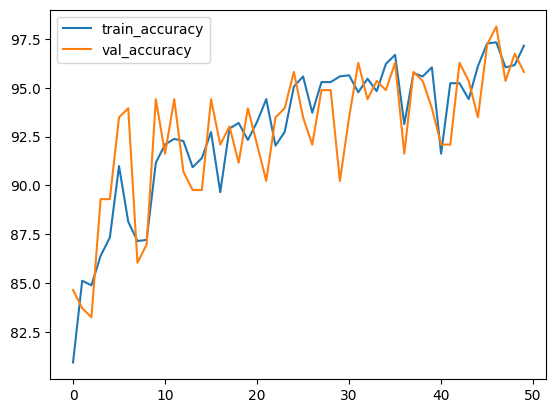

In [ ]:
training_accuracy =  torch.tensor(trainingEpoch_accuracy, device = 'cpu').numpy()

validation_accuracy = torch.tensor(validationEpoch_accuracy, device = 'cpu').numpy()

plt.plot(training_accuracy, label='train_accuracy')
plt.plot(validation_accuracy,label='val_accuracy')
plt.legend()
plt.show

In [ ]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))

tensor(98.1481, device='cuda:0')
Test accuracy: 98.15%


In [ ]:
for index, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break

<ipython-input-38-94c9414dd448>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(feature, device = 'cpu').numpy()


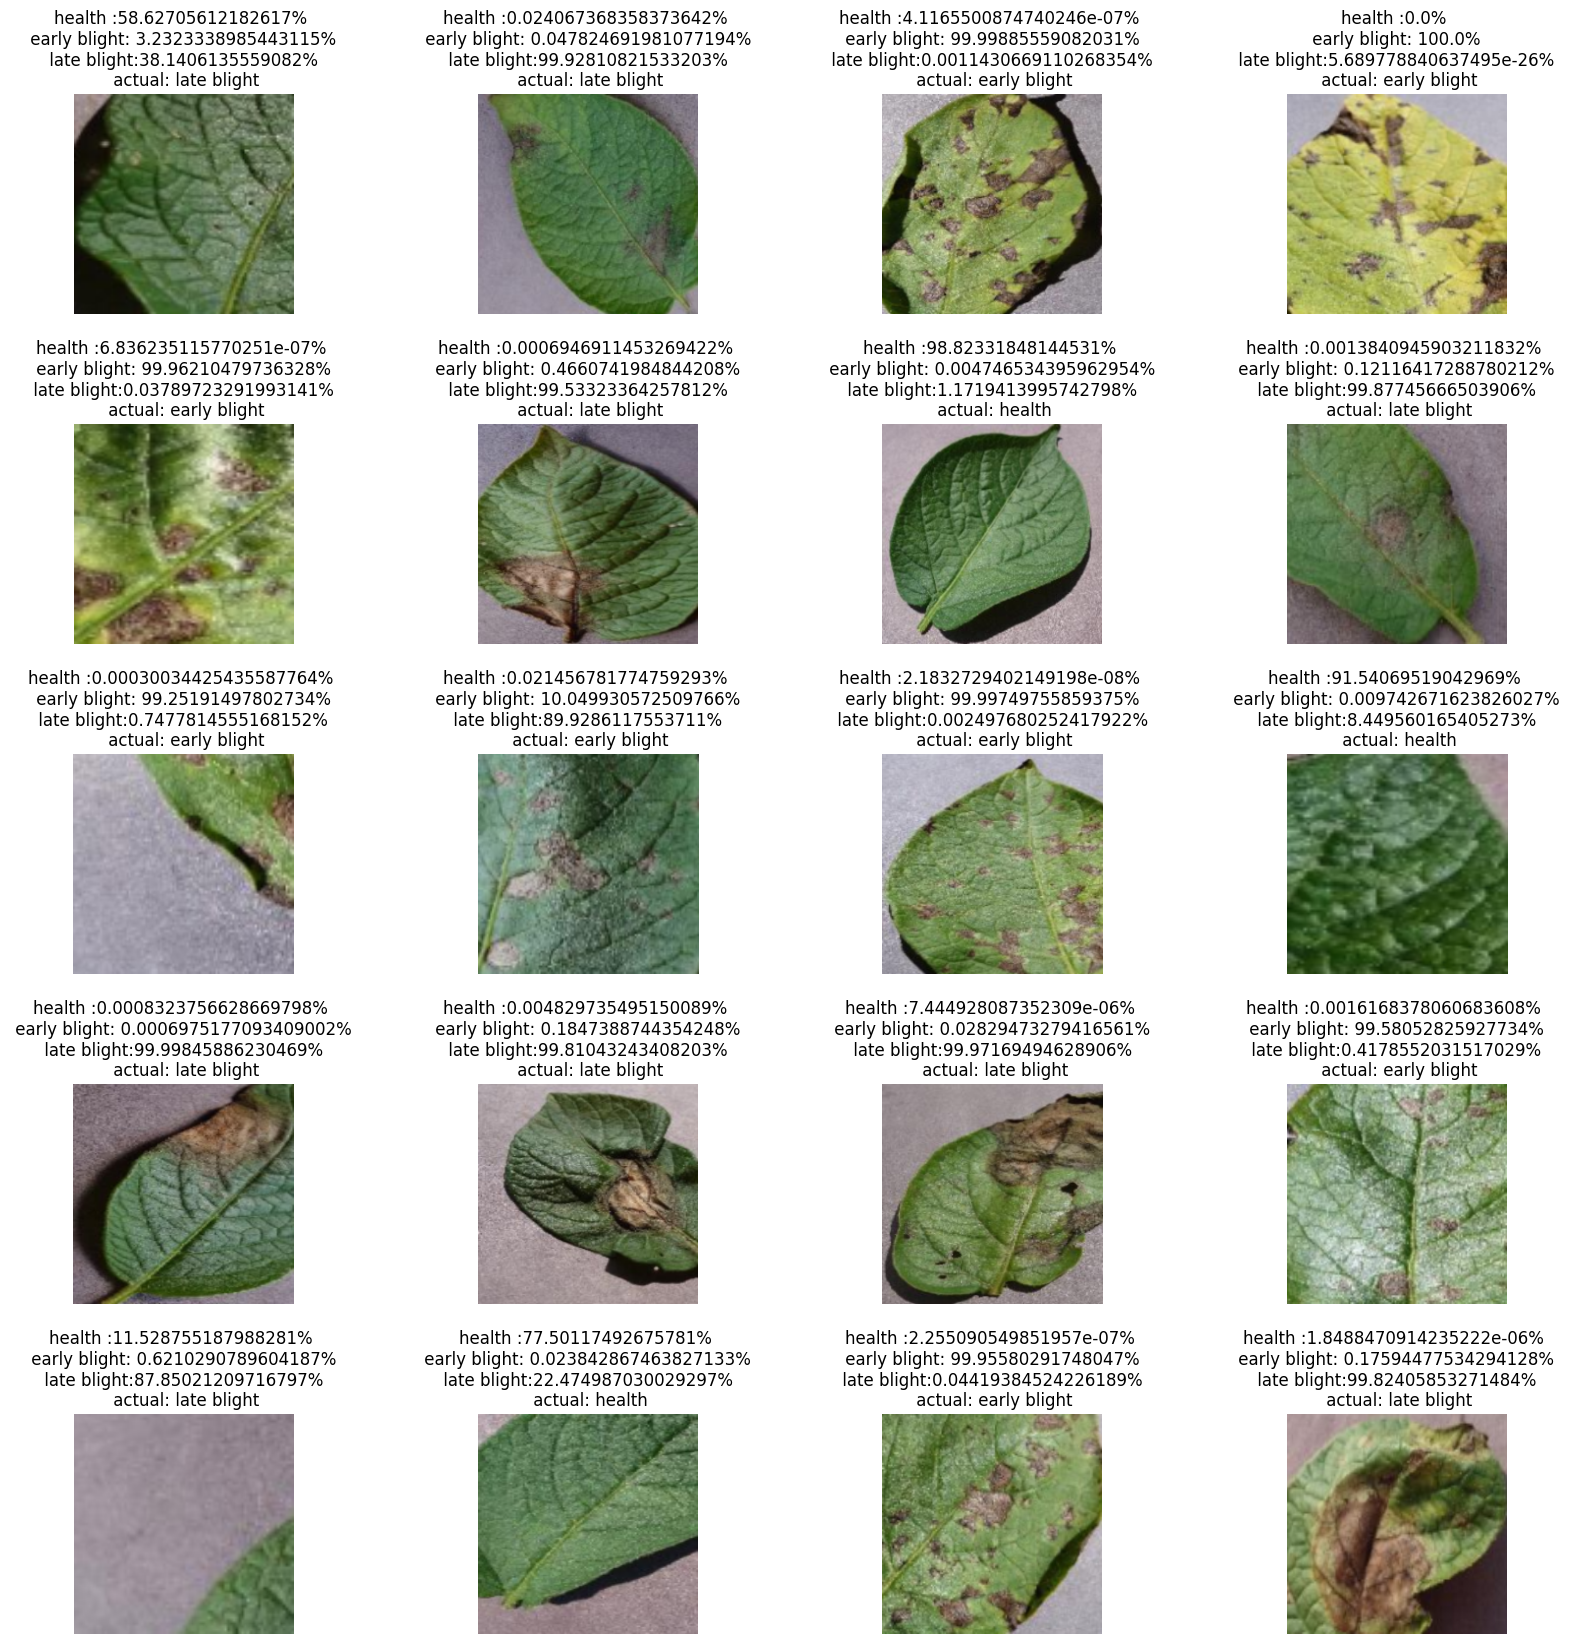

In [ ]:
model.eval()

fig = plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace=0.5)
for index, feature in enumerate(features):
  logits, probas = model(features[index, None].to(DEVICE))

  fig.add_subplot(5, 4, index + 1)
  actual = "health"
  if(targets[index] == 1):
    actual = "early blight"
  elif(targets[index] == 2):
    actual = "late blight"

  plt.title('health :{}% \n early blight: {}% \n late blight:{}% \n actual: {}'.format(probas[0][0]*100, probas[0][1]*100, probas[0][2]*100, actual))

  feature = torch.tensor(feature, device = 'cpu').numpy()
  plt.imshow(np.transpose(feature, (1, 2, 0)))
  plt.axis('off')
  if index == 19:
    plt.show()
    break